In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
import pickle

In [22]:
df = pd.read_csv("C:\\Users\\91878\\Downloads\\Churn_Modelling.csv")

In [23]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [24]:
# Explore data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [25]:
# Check for missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [26]:
df['Exited'].value_counts()   

Exited
0    7963
1    2037
Name: count, dtype: int64

In [27]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['Surname', 'Geography', 'Gender']

In [28]:
# Encoding categorical features
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])  # Male=1, Female=0
df['Geography'] = label_encoder.fit_transform(df['Geography']) 

In [29]:
# Selecting features and target
x = df.drop(columns=['Exited', 'Surname', 'CustomerId'])
y = df['Exited']

In [30]:
# Use SelectKBest to select top 5 best features
k = 7  # Select top 7 features
selector = SelectKBest(score_func=mutual_info_classif, k=k)
x_selected = selector.fit_transform(x, y)

mask = selector.get_support()        # Get the boolean mask of selected features
selected_features = x.columns[mask]       # Get the selected feature names
print("Selected features:", selected_features)      # Print the selected features

Selected features: Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts',
       'IsActiveMember'],
      dtype='object')


In [31]:
outliers = []
for feature in df[selected_features].select_dtypes(include=np.number).columns:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    # Capping and flooring outliers
    df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_selected, y, test_size=0.2, random_state=42)      # splitting the data into training data and test data
print(x_train.shape, x_test.shape, x_selected.shape)
print(y_train.shape, y_test.shape, y.shape)

(8000, 7) (2000, 7) (10000, 7)
(8000,) (2000,) (10000,)


In [33]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## 1. Logistic Regression

In [34]:
model = LogisticRegression(random_state=42)
model.fit(x_train_scaled, y_train)

y_train_prediction = model.predict(x_train_scaled)
training_data_accuracy = accuracy_score(y_train, y_train_prediction)
print("Accuracy on training data = ", training_data_accuracy)
print("Classification Report: \n", classification_report(y_train, y_train_prediction))
print("Confusion Matrix: \n", confusion_matrix(y_train, y_train_prediction))

y_test_pred_logistic = model.predict(x_test_scaled)
testing_data_accuracy = accuracy_score(y_test, y_test_pred_logistic)
print("\n\nAccuracy on testing data = ", testing_data_accuracy)
print("Classification Report: \n", classification_report(y_test, y_test_pred_logistic))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred_logistic))

Accuracy on training data =  0.806625
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      6356
           1       0.60      0.18      0.28      1644

    accuracy                           0.81      8000
   macro avg       0.71      0.57      0.58      8000
weighted avg       0.77      0.81      0.76      8000

Confusion Matrix: 
 [[6157  199]
 [1348  296]]


Accuracy on testing data =  0.816
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.61      0.18      0.28       393

    accuracy                           0.82      2000
   macro avg       0.72      0.58      0.59      2000
weighted avg       0.79      0.82      0.77      2000

Confusion Matrix: 
 [[1560   47]
 [ 321   72]]


## 2. Random Forest

In [35]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_scaled, y_train)

y_train_prediction = rf.predict(x_train_scaled)
training_data_accuracy = accuracy_score(y_train, y_train_prediction)
print("Accuracy on training data = ", training_data_accuracy)
print("Classification Report: \n", classification_report(y_train, y_train_prediction))
print("Confusion Matrix: \n", confusion_matrix(y_train, y_train_prediction))

y_test_pred_rf = rf.predict(x_test_scaled)
testing_data_accuracy = accuracy_score(y_test, y_test_pred_rf)
print("\n\nAccuracy on testing data = ", testing_data_accuracy)
print("Classification Report: \n", classification_report(y_test, y_test_pred_rf))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred_rf))

Accuracy on training data =  0.999625
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6356
           1       1.00      1.00      1.00      1644

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

Confusion Matrix: 
 [[6356    0]
 [   3 1641]]


Accuracy on testing data =  0.8615
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      1607
           1       0.71      0.49      0.58       393

    accuracy                           0.86      2000
   macro avg       0.80      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000

Confusion Matrix: 
 [[1530   77]
 [ 200  193]]


## 3. Support Vector Machine

In [36]:
svc = SVC(random_state=42)
svc.fit(x_train_scaled, y_train)

y_train_prediction = svc.predict(x_train_scaled)
training_data_accuracy = accuracy_score(y_train, y_train_prediction)
print("Accuracy on training data = ", training_data_accuracy)
print("Classification Report: \n", classification_report(y_train, y_train_prediction))
print("Confusion Matrix: \n", confusion_matrix(y_train, y_train_prediction))

y_test_pred_svc = svc.predict(x_test_scaled)
testing_data_accuracy = accuracy_score(y_test, y_test_pred_svc)
print("Accuracy on testing data = ", testing_data_accuracy)
print("Classification Report: \n", classification_report(y_test, y_test_pred_svc))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred_svc))

Accuracy on training data =  0.86025
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      6356
           1       0.85      0.39      0.53      1644

    accuracy                           0.86      8000
   macro avg       0.85      0.69      0.73      8000
weighted avg       0.86      0.86      0.84      8000

Confusion Matrix: 
 [[6239  117]
 [1001  643]]
Accuracy on testing data =  0.8615
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      1607
           1       0.81      0.39      0.52       393

    accuracy                           0.86      2000
   macro avg       0.84      0.68      0.72      2000
weighted avg       0.86      0.86      0.84      2000

Confusion Matrix: 
 [[1571   36]
 [ 241  152]]


## 4. Decision Tree

In [37]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train_scaled, y_train)

y_train_prediction = decision_tree.predict(x_train_scaled)
training_data_accuracy = accuracy_score(y_train, y_train_prediction)
print("Accuracy on training data = ", training_data_accuracy)
print("Classification Report: \n", classification_report(y_train, y_train_prediction))
print("Confusion Matrix: \n", confusion_matrix(y_train, y_train_prediction))

y_test_pred_dt = decision_tree.predict(x_test_scaled)
testing_data_accuracy = accuracy_score(y_test, y_test_pred_dt)
print("\n\nAccuracy on testing data = ", testing_data_accuracy)
print("Classification Report: \n", classification_report(y_test, y_test_pred_dt))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred_dt))

Accuracy on training data =  0.99975
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6356
           1       1.00      1.00      1.00      1644

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

Confusion Matrix: 
 [[6356    0]
 [   2 1642]]


Accuracy on testing data =  0.8105
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      1607
           1       0.52      0.54      0.53       393

    accuracy                           0.81      2000
   macro avg       0.70      0.71      0.70      2000
weighted avg       0.81      0.81      0.81      2000

Confusion Matrix: 
 [[1410  197]
 [ 182  211]]


## 5. K-Nearest Neighbors

In [38]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_scaled, y_train)

y_train_prediction = knn.predict(x_train_scaled)
training_data_accuracy = accuracy_score(y_train, y_train_prediction)
print("Accuracy on training data = ", training_data_accuracy)
print("Classification Report: \n", classification_report(y_train, y_train_prediction))
print("Confusion Matrix: \n", confusion_matrix(y_train, y_train_prediction))

y_test_pred_knn = knn.predict(x_test_scaled)
testing_data_accuracy = accuracy_score(y_test, y_test_pred_knn)
print("\n\nAccuracy on testing data = ", testing_data_accuracy)
print("Classification Report: \n", classification_report(y_test, y_test_pred_knn))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred_knn))

Accuracy on training data =  0.885625
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      6356
           1       0.81      0.58      0.67      1644

    accuracy                           0.89      8000
   macro avg       0.85      0.77      0.80      8000
weighted avg       0.88      0.89      0.88      8000

Confusion Matrix: 
 [[6135  221]
 [ 694  950]]


Accuracy on testing data =  0.839
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      1607
           1       0.63      0.45      0.52       393

    accuracy                           0.84      2000
   macro avg       0.75      0.69      0.71      2000
weighted avg       0.83      0.84      0.83      2000

Confusion Matrix: 
 [[1501  106]
 [ 216  177]]


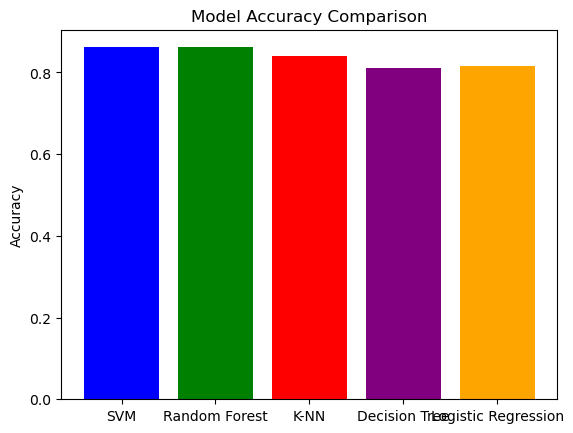

In [39]:
# Final comparison of the model accuracies
models = ['SVM', 'Random Forest', 'K-NN', 'Decision Tree', 'Logistic Regression']
accuracies = [
    accuracy_score(y_test, y_test_pred_svc),
    accuracy_score(y_test, y_test_pred_rf),
    accuracy_score(y_test, y_test_pred_knn),
    accuracy_score(y_test, y_test_pred_dt),
    accuracy_score(y_test, y_test_pred_logistic)
]

plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

In [40]:
with open('customer_churn_prediction.pickle', 'wb') as file:
     pickle.dump(rf, file)